In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/NLU

/content/drive/MyDrive/NLU


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Apr 18 23:25:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from IPython.display import clear_output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
pip install transformers

In [ ]:
pip install Sentencepiece

In [ ]:
import pickle # reading in our data

import torch # pytorch
from torch.utils.data import DataLoader # this helps us iterate over our data efficiently
from tqdm import tqdm

In [ ]:
with open('/content/drive/MyDrive/NLU/covidqa/covid_train_contexts.pkl', 'rb') as f1:
  train_contexts = pickle.load(f1)

with open('/content/drive/MyDrive/NLU/covidqa/covid_train_questions.pkl', 'rb') as f2:
  train_questions = pickle.load(f2)

with open('/content/drive/MyDrive/NLU/covidqa/covid_train_answers.pkl', 'rb') as f3:
  train_answers = pickle.load(f3)

with open('/content/drive/MyDrive/NLU/covidqa/covid_val_contexts.pkl', 'rb') as f1:
  val_contexts = pickle.load(f1)

with open('/content/drive/MyDrive/NLU/covidqa/covid_val_questions.pkl', 'rb') as f2:
  val_questions = pickle.load(f2)

with open('/content/drive/MyDrive/NLU/covidqa/covid_val_answers.pkl', 'rb') as f3:
  val_answers = pickle.load(f3)

In [ ]:
print(type(train_questions))
print(type(train_contexts))
print(type(train_answers))
print(len(train_questions))
print(len(train_contexts))
print(len(train_answers))

<class 'list'>
<class 'list'>
<class 'list'>
1615
1615
1615


In [ ]:
print(len(val_answers))

404


In [ ]:
print("Question")
print(train_questions[0])
print("Answer")
print(train_answers[0])
# print("Context")
# print(train_contexts[0])

Question
What is the main cause of HIV-1 infection in children?
Answer
{'text': 'Mother-to-child transmission (MTCT) is the main cause of HIV-1 infection in children worldwide. ', 'answer_start': 370}


In [ ]:
# the actual answer
expected_answer = train_answers[1]['text']
# start index of the answer
start_index = train_answers[1]['answer_start']
end_index = start_index + len(expected_answer)
print(start_index)
print(len(expected_answer))
print(end_index)
print(train_answers[1])

2003
126
2129
{'text': 'DC-SIGNR plays a crucial role in MTCT of HIV-1 and that impaired placental DC-SIGNR expression increases risk of transmission.', 'answer_start': 2003}


In [ ]:
def add_end_index(answers, contexts):

  # loop over each context-answer pair
  for answer, context in zip(answers, contexts):

    # the actual answer
    expected_answer = answer['text']

    # start index of the answer
    start_index = answer['answer_start']

    # end index
    end_index = start_index + len(expected_answer)

    # take into account if answer is off by a couple characters
    if context[start_index:end_index] == expected_answer:
      answer['answer_end'] = end_index
    else:
      # if answer is off by 1 or 2 tokens
      for i in [1, 2]:
        if context[start_index-i:end_index-i] == expected_answer:
          answer['answer_start'] = start_index - i
          answer['answer_end'] = end_index - i

In [ ]:
# apply our function above to dig up all the answer_start and end for each context-answer pair
add_end_index(train_answers, train_contexts)
add_end_index(val_answers, val_contexts)
# add_end_index(val_answers, val_contexts)
print(train_answers[0])
print(val_answers[0])

{'text': 'Mother-to-child transmission (MTCT) is the main cause of HIV-1 infection in children worldwide. ', 'answer_start': 370, 'answer_end': 466}
{'text': 'there are also evidence of reduced type I (IFNβ) and III (IFNλ) interferon production due to type 2-skewed inflammation, which contributes to imperfect clearance of the virus resulting in persistence of viral components, or the live virus in the airway epithelium ', 'answer_start': 17454, 'answer_end': 17718}


In [ ]:
# # from transformers import DistilBertTokenizerFast
# from transformers import AlbertTokenizerFast
# # defining the tokenizer we are going to use
# # tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
# # apply tokenizer to our training and validation datasets
# train_tokenized = tokenizer(train_contexts, train_questions, truncation=True, padding=True)

In [ ]:
# tokenizer.decode(train_tokenized['input_ids'][2])

In [ ]:
# tokenizer.decode(train_tokenized['input_ids'][1])

In [ ]:
# train_tokenized.keys()

In [ ]:
# len(train_tokenized["input_ids"][0])

In [ ]:
# train_tokenized["input_ids"][:2]

In [ ]:
# from transformers import DistilBertTokenizerFast
from transformers import RobertaTokenizerFast
# defining the tokenizer we are going to use
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

In [ ]:
# question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"

# inputs = tokenizer(question, text, return_tensors="pt")
# tokenizer.decode(inputs['input_ids'][0])

In [ ]:
# from transformers import XLNetForQuestionAnswering, XLNetTokenizerFast

# tokenizer = XLNetTokenizerFast.from_pretrained('jkgrad/xlnet-base-squadv2')
# example_train_tokenized = tokenizer(train_questions, train_contexts)
# tokenizer.decode(example_train_tokenized['input_ids'][0])

In [ ]:
# example_train_tokenized.keys()

In [ ]:
# apply tokenizer to our training and validation datasets
train_tokenized = tokenizer(train_questions, train_contexts, truncation=True, padding=True)
val_tokenized = tokenizer(val_questions, val_contexts, truncation=True, padding=True)

In [ ]:
# train_tokenized_max_l = tokenizer(
#     train_questions,
#     train_contexts,
#     max_length=500,
#     truncation="only_second",
#     stride=50,
#     return_overflowing_tokens=True,
# )

# val_tokenized_max_l = tokenizer(
#     val_questions,
#     val_contexts,
#     max_length=500,
#     truncation="only_second",
#     stride=50,
#     return_overflowing_tokens=True,
# )

In [ ]:
print(train_tokenized[0])
print(val_tokenized[0])

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [ ]:
# print(train_tokenized_max_l[0])
# print(val_tokenized_max_l[0])

In [ ]:
tokenizer.decode(train_tokenized['input_ids'][0])

'<s>What is the main cause of HIV-1 infection in children?</s></s>Functional Genetic Variants in DC-SIGNR Are Associated with Mother-to-Child Transmission of HIV-1\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC2752805/\n\nBoily-Larouche, Geneviève; Iscache, Anne-Laure; Zijenah, Lynn S.; Humphrey, Jean H.; Mouland, Andrew J.; Ward, Brian J.; Roger, Michel\n2009-10-07\nDOI:10.1371/journal.pone.0007211\nLicense:cc-by\n\nAbstract: BACKGROUND: Mother-to-child transmission (MTCT) is the main cause of HIV-1 infection in children worldwide. Given that the C-type lectin receptor, dendritic cell-specific ICAM-grabbing non-integrin-related (DC-SIGNR, also known as CD209L or liver/lymph node–specific ICAM-grabbing non-integrin (L-SIGN)), can interact with pathogens including HIV-1 and is expressed at the maternal-fetal interface, we hypothesized that it could influence MTCT of HIV-1. METHODS AND FINDINGS: To investigate the potential role of DC-SIGNR in MTCT of HIV-1, we carried out a genetic as

In [ ]:
def add_token_positions(tokenized_data, answers):
  # let's define a couple lists to keep track of our start/end tokens
  start_positions = [] # aggregate all start positions for each sample
  end_positions = [] # aggregate all end positions for each sample

  # loop over the answers list
  for i in range(len(answers)):
    # add the start and end encodings to our lists
    start_positions.append(tokenized_data.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(tokenized_data.char_to_token(i, answers[i]['answer_end']))

    # if no start position, the answer passage was truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
    
    # if we can't find the end positions, then we want to shift characters left until we do find it
    shift = 1
    while end_positions[-1] is None:
      end_positions[-1] = tokenized_data.char_to_token(i, answers[i]['answer_end'] - shift)
      shift += 1
  
  tokenized_data.update({'start_positions': start_positions, 'end_positions': end_positions})

In [ ]:
# apply function to train and validations data
add_token_positions(train_tokenized, train_answers)
add_token_positions(val_tokenized, val_answers)

In [ ]:
train_tokenized.keys()

dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])

In [ ]:
class Custom_Dataset(torch.utils.data.Dataset):
  # constructor
  def __init__(self, encodings):
    self.encodings = encodings
  
  # Query to get a specific item at an index in our dataset
  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # comprehension (shortcut)

  # returns the length of our dataset
  def __len__(self):
    return len(self.encodings.input_ids)

In [ ]:
# Datasets for the training and validations sets
train_data = Custom_Dataset(train_tokenized)
val_data = Custom_Dataset(val_tokenized)

In [ ]:
# Used to help us iterate over our dataset conveniently, especially when we have batches
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)

In [ ]:
from transformers import RobertaForQuestionAnswering # This is the BERT model used for question answering

# BERT model already finetuned for question answering
model = RobertaForQuestionAnswering.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

In [ ]:
# from transformers import AdamW

lr= 1e-5 
optimizer= torch.optim.AdamW(model.parameters(), lr=lr)

In [ ]:
model = model.to(device)
print(model)

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
from IPython.display import clear_output

In [ ]:
# def train(model, train_dataloader):
best_train_loss = float('inf')
train_accuracies = []
losses = []
# run loop 3 times
for epoch in range(10):
  # first, set the mode of the model to train
  model.train()

  # progress bar
  loop = tqdm(train_dataloader, leave=True)

  # loop over each batch 
  for batch in loop:
    # zero out the optimizer
    optimizer.zero_grad()

    # grab the batch attributes and attach them to the GPU device
    input_ids, attention_mask, start_positions, end_positions = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['start_positions'].to(device), batch['end_positions'].to(device)

    # Feedforward!!!
    outputs = model(input_ids, attention_mask, start_positions=start_positions, end_positions=end_positions)

    # Compute the Loss
    loss = outputs[0]

    # BACKPROPAGATION!!!!
    loss.backward()

    # update parameters for the next run
    optimizer.step()

    losses.append(loss.item())

    # get the prediction for the start and end token for answer
    start_probs = outputs['start_logits']
    end_probs = outputs['end_logits']
    
    start_pred = torch.argmax(start_probs, dim=1)
    end_pred = torch.argmax(end_probs, dim=1)
    
    # append the accuracy
    train_accuracies.append(((start_pred == start_positions).sum() / len(start_pred)).item())
    train_accuracies.append(((end_pred == end_positions).sum() / len(end_pred)).item())
    
    avg_acc = sum(train_accuracies) / len(train_accuracies)
    if loss.item() < best_train_loss:
      best_train_loss = loss.item()
      torch.save(model.state_dict(), 'Roberta_QA.pt')

    print(f'[{epoch + 1}] \nloss_total: {loss.item():.2f},\nTrain_accuracy: {avg_acc*100:.2f} %')
    clear_output(wait=True) 
    # display some stuff here
    loop.set_description(f'Epoch {epoch}')
    loop.set_postfix(loss=loss.item())

Epoch 9: 100%|██████████| 202/202 [02:44<00:00,  1.23it/s, loss=0.00017]


In [ ]:
import pickle

with open("train_loss", "wb") as fp:   #Pickling
  pickle.dump(losses, fp)

with open("train_accuracy", "wb") as fp:   #Pickling
  pickle.dump(train_accuracies, fp)

Text(0, 0.5, 'acc')

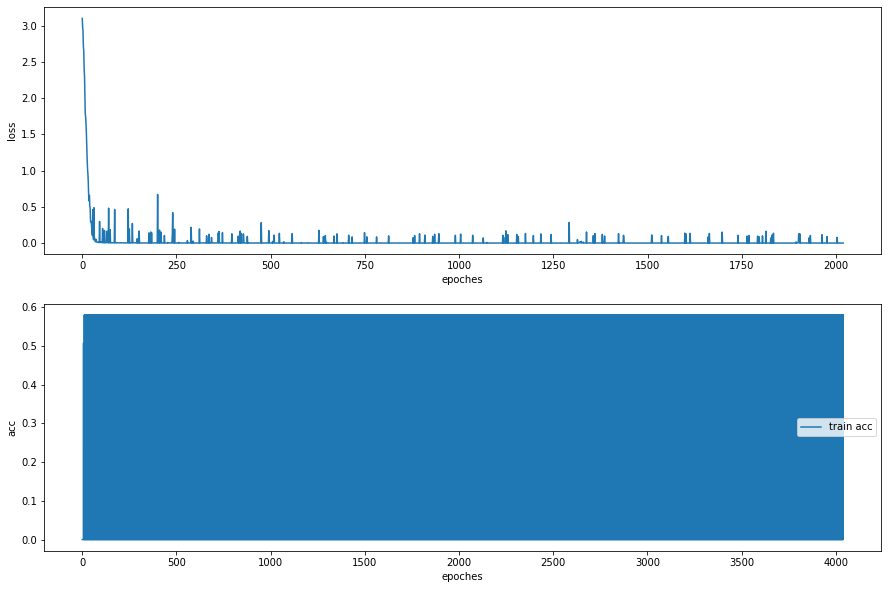

In [ ]:
# write code here for 4.5
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(losses, label = 'train loss')
ax2.plot(train_accuracies, label = 'train acc')
plt.legend()
ax1.set_xlabel('epoches')
ax1.set_ylabel('loss')
ax2.set_xlabel('epoches')
ax2.set_ylabel('acc')


In [ ]:

model.load_state_dict(torch.load('/content/drive/MyDrive/NLU/Roberta_QA.pt'))
best_train_loss = float('inf')
test_accuracies = []
test_losses = []
# run loop 3 times
for epoch in range(10):
  # first, set the mode of the model to train
  # model.train()

  # progress bar
  loop = tqdm(val_dataloader, leave=True)
  with torch.no_grad():
    # loop over each batch 
    for batch in loop:
      # zero out the optimizer
      # optimizer.zero_grad()

      # grab the batch attributes and attach them to the GPU device
      input_ids, attention_mask, start_positions, end_positions = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['start_positions'].to(device), batch['end_positions'].to(device)

      # Feedforward!!!
      outputs = model(input_ids, attention_mask, start_positions=start_positions, end_positions=end_positions)

      # Compute the Loss
      loss = outputs[0]

      # BACKPROPAGATION!!!!
      # loss.backward()

      # update parameters for the next run
      # optimizer.step()

      test_losses.append(loss.item())
      
      # get the prediction for the start and end token for answer
      start_probs = outputs['start_logits']
      end_probs = outputs['end_logits']
      
      start_pred = torch.argmax(start_probs, dim=1)
      end_pred = torch.argmax(end_probs, dim=1)
      
      # append the accuracy
      test_accuracies.append(((start_pred == start_positions).sum() / len(start_pred)).item())
      test_accuracies.append(((end_pred == end_positions).sum() / len(end_pred)).item())
      
      avg_acc = sum(test_accuracies) / len(test_accuracies)
      print(f'[{epoch + 1}] \nloss_total: {loss.item():.2f},\nTrain_accuracy: {avg_acc*100:.2f} %')
      clear_output(wait=True) 
      # display some stuff here
      loop.set_description(f'Epoch {epoch}')
      loop.set_postfix(loss=loss.item())

Epoch 9: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s, loss=4.69e-5]


In [ ]:
test_accuracies[-1]

1.0

In [ ]:
import pickle

with open("train_loss", "wb") as fp:   #Pickling
  pickle.dump(test_losses, fp)

with open("train_accuracy", "wb") as fp:   #Pickling
  pickle.dump(test_accuracies, fp)

In [ ]:
len(test_accuracies)

1020

Text(0, 0.5, 'acc')

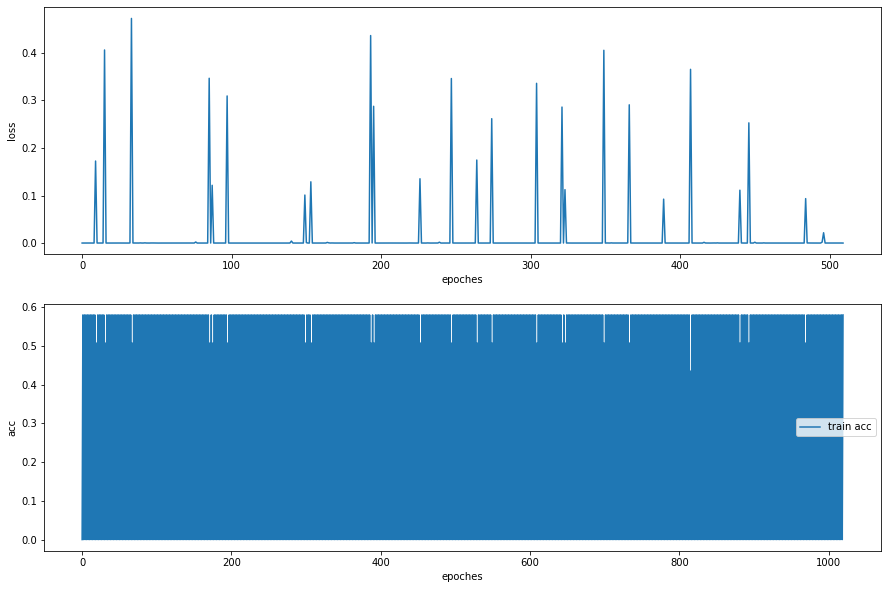

In [ ]:
# write code here for 4.5
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(test_losses, label = 'train loss')
ax2.plot(test_accuracies, label = 'train acc')
plt.legend()
ax1.set_xlabel('epoches')
ax1.set_ylabel('loss')
ax2.set_xlabel('epoches')
ax2.set_ylabel('acc')


In [ ]:
val_questions[0]

'What are other  effects?'

In [ ]:
val_contexts[0]

'Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Chow, Vincent T.; Wang, De Yun\nDate: 2020-02-25\nDOI: 10.3389/fcell.2020.00099\nLicense: cc-by\n\nAbstract: Respiratory virus infection is one of the major sources of exacerbation of chronic airway inflammatory diseases. These exacerbations are associated with high morbidity and even mortality worldwide. The current understanding on viral-induced exacerbations is that viral infection increases airway inflammation which aggravates disease symptoms. Recent advances in in vitro air-liquid interface 3D cultures, organoid cultures and the use of novel human and animal challenge models have evoked new un

In [ ]:
val_answers[0]

{'answer_end': 17718,
 'answer_start': 17454,
 'text': 'there are also evidence of reduced type I (IFNβ) and III (IFNλ) interferon production due to type 2-skewed inflammation, which contributes to imperfect clearance of the virus resulting in persistence of viral components, or the live virus in the airway epithelium '}

In [ ]:
# ans_text = []
# ans_start = []
# ans_end = []
# for i in range(len(val_answers)):
#   ans_text.append(val_answers[i]["text"])
#   ans_start.append(val_answers[i]["answer_start"])
#   ans_end.append(val_answers[i]["answer_end"])

# print(ans_text[:2])
# print(ans_start[:2])
# print(ans_end[:2])

# ans_dict = {
#   "text": ans_text,
#   "answer_start": ans_start,
#   "answer_end": ans_end
# }

# print("Train Dict")
# print(ans_dict.keys())
# print(ans_dict['text'][:2])
# print(ans_dict['answer_start'][:2])
# print(ans_dict['answer_end'][:2])

In [ ]:
# answers_maps_key_list = list(ans_dict.keys())
# answers_maps_val_list = list(ans_dict.values())
# print(answers_maps_key_list)
# print(answers_maps_val_list[1][2])

# position = answers_maps_val_list[1].index(18044)

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

question = val_questions[:2]
context = val_contexts[:2]

test_tokenized = tokenizer(question, context, truncation=True, padding=True)
print(test_tokenized.keys())
# tokens = tokenizer.convert_ids_to_tokens(test_tokenized) #input tokens
print(val_tokenized[0])
add_token_positions(test_tokenized, val_answers[:2])
print(test_tokenized.keys())
test_data = Custom_Dataset(test_tokenized)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

dict_keys(['input_ids', 'attention_mask'])
Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])


In [ ]:
print(test_tokenized.input_ids[0][:2])
print(len(test_tokenized.input_ids[0]))

[0, 2264]
512


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NLU/Roberta_QA.pt'))
model = model.to(device)

# run loop 3 times
# for epoch in range(1):
with torch.no_grad():
  # loop over each batch 
  i = 0
  for batch in test_dataloader:
    # grab the batch attributes and attach them to the GPU device
    input_ids, attention_mask, start_positions, end_positions = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['start_positions'].to(device), batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask = attention_mask)
    loss = outputs[0]
    start_probs = outputs['start_logits']
    end_probs = outputs['end_logits']
    
    start_pred = torch.argmax(start_probs, dim=1)
    end_pred = torch.argmax(end_probs, dim=1)
    # start_pred = torch.argmin(start_probs, dim=1)
    # end_pred = torch.argmin(end_probs, dim=1)
    # print(start_pred, end_pred)
    start_pred = start_pred.detach().to("cpu").numpy()
    end_pred = end_pred.detach().to("cpu").numpy()

    # print(start_pred[0], end_pred[0])

    predict_answer_tokens = val_tokenized.input_ids[0][end_pred[0] + 1 : start_pred[0]]
    # print(val_tokenized.input_ids[0])
    # print(val_tokenized.input_ids[0][end_pred[0] +1: start_pred[0]])

    predicted_answer = tokenizer.decode(predict_answer_tokens)
    print("Question ",i+1,":\n",question[i],'\n')
    print("Predicted Answer ",i+1,":\n",predicted_answer,'\n')
    i += 1

Question  1 :
 What are other  effects? 

Predicted Answer  1 :
 ions in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/

SHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4

Authors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Chow, Vincent T.; Wang, De Yun
Date: 2020-02-25
DOI: 10.3389/fcell.2020.00099
License: cc-by

Abstract: Respiratory virus infection is one of the major sources of exacerbation of chronic airway inflammatory diseases. These exacerbations are associated with high morbidity and even mortality worldwide. The current understanding on viral-induced exacerbations is that viral infection increases airway inflammation which aggravates disease symptoms. Recent advances in in vitro air-liquid interface 3D cultures, organoid cultures and the use of novel human and animal challe

In [ ]:
# tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# question = val_questions[:2]
# context = val_contexts[:2]

# test_tokenized = tokenizer(question, context, truncation=True, padding=True)
# print(test_tokenized.keys())
# # tokens = tokenizer.convert_ids_to_tokens(test_tokenized) #input tokens
# print(val_tokenized[0])
# add_token_positions(test_tokenized, val_answers[:2])
# print(test_tokenized.keys())
# test_data = Custom_Dataset(test_tokenized)
# test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/NLU/Roberta_QA.pt'))
# model = model.to(device)

# # run loop 3 times
# # for epoch in range(1):
# with torch.no_grad():
#   # loop over each batch 
#   i = 0
#   for batch in test_dataloader:
#     # grab the batch attributes and attach them to the GPU device
#     input_ids, attention_mask= batch['input_ids'].to(device), batch['attention_mask'].to(device)
#     outputs = model(input_ids, attention_mask = attention_mask)
#     loss = outputs[0]
#     start_probs = outputs['start_logits']
#     end_probs = outputs['end_logits']
#     print(torch.argmin(start_probs, dim=1), torch.argmin(end_probs, dim=1))
#     start_pred = torch.argmax(start_probs, dim=1)
#     end_pred = torch.argmax(end_probs, dim=1)
#     print(start_pred, end_pred)
#     ans_tokens = input_ids[torch.argmax(start_pred) : torch.argmax(end_pred)+1]
#     # print(ans_tokens)
#     answer_tokens = tokenizer.convert_ids_to_tokens(ans_tokens , skip_special_tokens=True)
#     # print(start_pred[0], end_pred[0])
#     # print(val_tokenized.input_ids[0])
#     # print(val_tokenized.input_ids[0][end_pred[0] +1: start_pred[0]])

#     predicted_answer = tokenizer.convert_tokens_to_string(answer_tokens)
#     print("Question ",i+1,":\n",question[i],'\n')
#     print("Predicted Answer ",i+1,":\n",predicted_answer,'\n')
#     i += 1

In [ ]:
# tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# question = val_questions[0]
# context = val_contexts[0]

# encoding = tokenizer.encode_plus(question, context)
# input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]